## Partie 1

Dans ce projet, on étudie et applique la méthode **RANSAC (RANdom SAmple Consensus)**, une technique d’**estimation robuste** utilisée pour ajuster un modèle en présence de nombreuses **valeurs aberrantes**. On commence par développer une **implémentation personnelle** du RANSAC, tout en utilisant le modèle de **régression linéaire de scikit-learn** comme composant de base.
Une fois cette version codée, on compare ses performances avec celles d’une **régression linéaire classique** ainsi qu’avec l’**implémentation RANSAC** fournie par scikit-learn. L’ensemble des méthodes est ensuite appliqué au **jeu de données du premier laboratoire** afin de vérifier que l’implémentation reproduit correctement le comportement attendu. Des **visualisations** sont créées pour afficher les différents modèles ajustés.

On étudie également la **robustesse du RANSAC** à travers plusieurs scénarios comportant des proportions variables de **points bruités**. Les cas testés incluent :
– l’ajout d’**outliers fortement perturbés** et dispersés autour de la droite des inliers ;
– un **bruit uniquement positif**, où tous les points perturbés se trouvent au-dessus des données réelles ;
– un **bruit appliqué spécifiquement** aux points situés dans la partie basse du nuage de points.
Pour chaque situation, on analyse l’impact du bruit sur l’**estimation finale** et on compare les comportements observés.

Dans une deuxième étape, on développe une **variante alternative du RANSAC** reposant sur une logique inverse : au lieu de laisser les données voter pour les modèles, ce sont les **modèles générés** à chaque sous-échantillonnage qui **votent pour les points** les plus cohérents. Après un nombre d’itérations donné, on sélectionne un **pourcentage fixe des points les mieux votés**, puis on entraîne un **modèle final** uniquement sur ces points. Les performances de cette variante sont ensuite évaluées sur les mêmes jeux de données ou sur des **variations générées**.

La dernière partie du travail vise à montrer que RANSAC constitue un **cadre général d’estimation robuste**, au-delà de la régression linéaire. On adapte d’abord le principe de RANSAC pour déterminer de manière robuste le **centre d’un nuage de points**, afin d’obtenir un représentant proche de la **moyenne réelle des inliers** malgré la présence d’outliers.

On étend ensuite cette idée au **clustering**, en utilisant un algorithme de type **k-means** comme modèle interne. Une version **RANSAC-k-means** est proposée, implémentée et illustrée sur un ou plusieurs exemples pour montrer ses avantages et ses limites.

Enfin, on rédige un **pseudo-code général** décrivant la manière dont le principe de RANSAC peut être élargi à tout problème d’**estimation** ou d’**apprentissage statistique**.




## Solution

**a1)** le but de cette partie  est d'implémenter et analyser l'algorithme de ransac pour la régression linéaire, ensuite on le compare à la régression simple et ransac de scikit-learn.

Étapes suivie pour l'implémentation :

* chargement des données 
* A chaque itération, un sous-ensemble de n  est sélectionné aléatoirement parmi les données
* Sélection des inliers (Les points pour lesquels l'erreur de prédiction est inférieure au seuil t sont considérés comme des inliers)
* Si le nombre d'inliers dépasse le seuil d, nous réajustons le modèle à ces points.

ensuite j'ai fait une comparaison  avec la régression linéaire simple et RANSAC de scikit-learn 



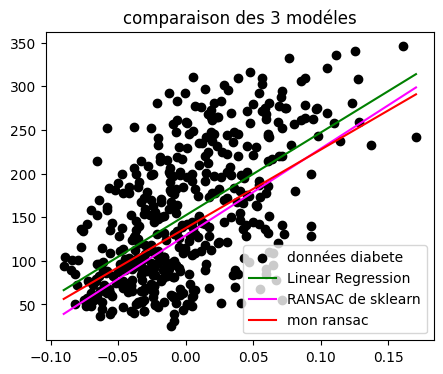

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error

#importer les donnes diabetes que j'ai utilisé 
diabetes = datasets.load_diabetes()
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

#implémentation de ransac à partir de wikepedia
def mon_ransac(X, y, n, k, t, d):

    #n: le nbr de points sélectionnés aléatoirement pour chaque itération.
    #k: le nbr d'itérations à exécuter pour trouver le meilleur modèle.
    #t: seuil d'erreur tolérée pour définir si un point est considéré comme un inlier
    #d: le nombre minimal d'inliers pour ajuster un modèle

    #initialisation on commence par un modéle de regression linéaire qui vas servir 
    #à ajuster des sous ensembles de données
    model = LinearRegression()
    meil_mod = None
    meil_ereur = float('inf')
    
    #j'ai utilisé une boucle pour que à chaque itération un sous ensemble de n est sélectionné
    #aléatoirement et un modéle est ajusté 
    for _ in range(k):
        i = np.random.choice(len(X), n, replace=False)
        inlier_x = X[i]
        inlier_y = y[i]
        
        model.fit(inlier_x, inlier_y)
        
        conf_inlier = []

        #on utilise ce modèle pour prédire les valeurs des autres points
        for i in range(len(X)):
            if np.abs(y[i] - model.predict(X[i].reshape(1, -1))) < t:
                conf_inlier.append(i)
        

        #Si le nombre d'inliers dépasse le seuil d on réajuste le modèle à ces points.
        if len(conf_inlier) > d:
            conf_inlier_X = X[conf_inlier]
            conf_inlier_y = y[conf_inlier]
            model.fit(conf_inlier_X, conf_inlier_y)
            
            this_error = mean_squared_error(conf_inlier_y, model.predict(conf_inlier_X))
            
            #mettre à jour le meilleur modéle 
            if this_error < meil_ereur:
                meil_mod = model
                meil_ereur = this_error
    
    return meil_mod

#j'ai comparé avec la régression linéaire simple et ransac de scikit learn
lin_reg = LinearRegression()
lin_reg.fit(X, y)

ransac_sklearn = RANSACRegressor()
ransac_sklearn.fit(X, y)

monransac = mon_ransac(X, y, n=20, k=100, t=10, d=40)

#j'ai utilisé 100 valeurs de X
choix_x = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X1 = lin_reg.predict(choix_x)
X2 = ransac_sklearn.predict(choix_x)
X3 = monransac.predict(choix_x)

#pour enfin ploter le graphe qui représente les données diabéte et et 3 modéle 
# que je vais comparer pour comparer et voir les performances


plt.figure(figsize=(5, 4))
plt.scatter(X, y, color='black', marker='o', label='données diabete')
plt.plot(choix_x, X1, color='green', label='Linear Regression')
plt.plot(choix_x, X2, color='magenta', label='RANSAC de sklearn')
plt.plot(choix_x, X3, color='red', label='mon ransac')
plt.legend()
plt.title('comparaison des 3 modéles')
plt.xlabel('')
plt.ylabel('')
plt.show()





**Cette figure compare trois méthodes de régression sur les données de diabète:**

* la régression linéaire simple (verte)
* le RANSAC de scikit-learn (magenta) 
* mon implémentation de RANSAC (rouge)

on observe que Ransac implémenté est trés proches de celle de scikit-learn et linear régression, donc l'algorithme a été correctement implémenté et qu'il identifie efficacement les inliers pour construire un bon modèle.

En terme de performances, mon implémentation de RANSAC est comparable à celle de scikit-learn, elle capture efficacement les inliers ce qui valide la bonne conception de mon algorithme.

**a2)** dans cette partie on vas tester le RANSAC implémenté et celui de scikit learn et régression linéaire en appliquant différent type de bruit(gaussien, positif, et les y les plus faibles) afin de comparer les performances de l'algorithme dans des situations variées et observer comment il gère les outliers.


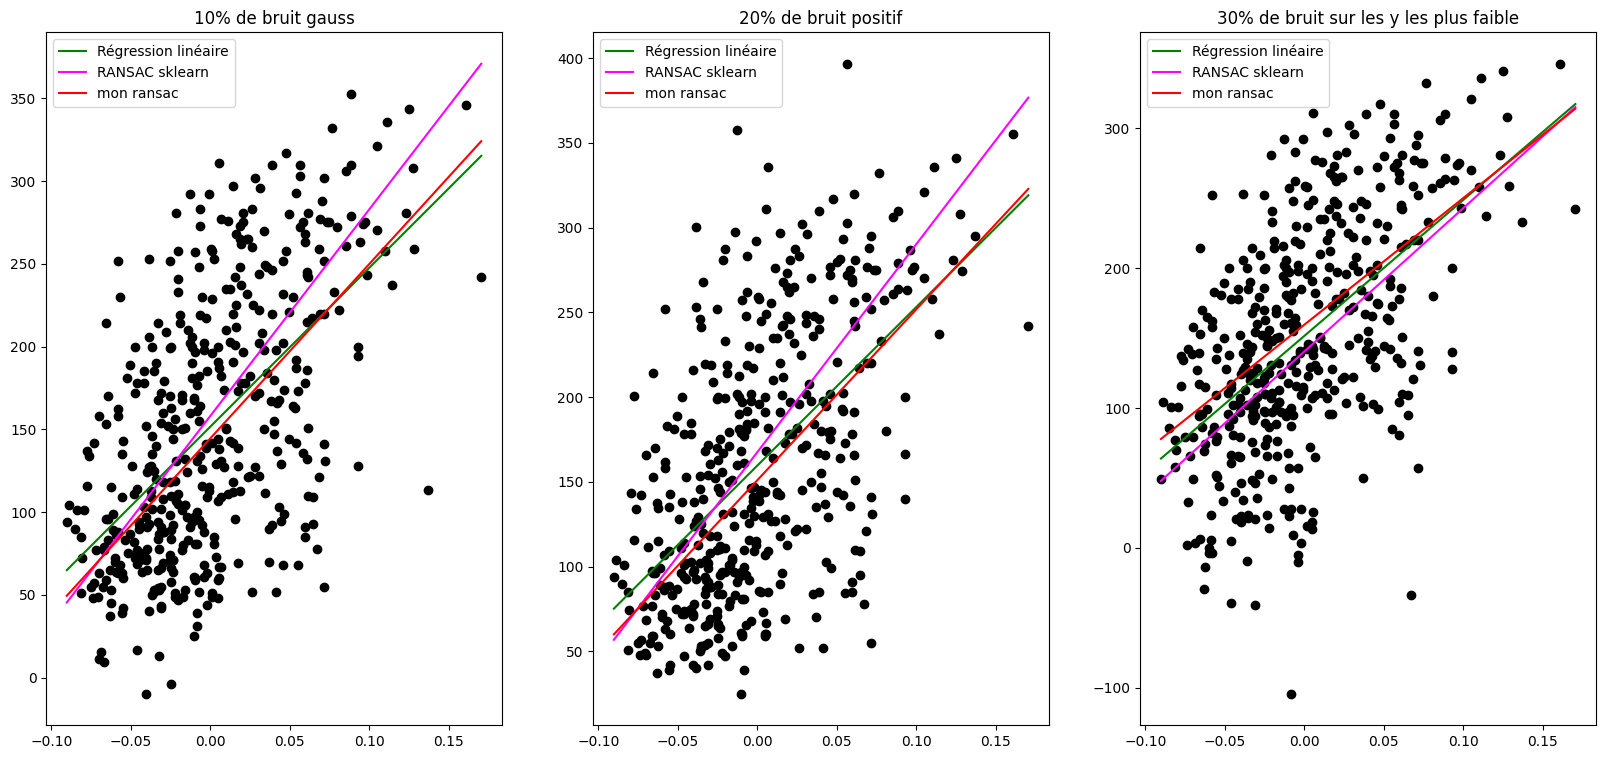

In [5]:
#cette fonction permet d'ajouter des bruits différents au données 

def ajouter_bruit(X, y, p, bruit='gaussien'):

    # p : c'est le pourcentage de buit 
    # bruit: peut prendre les valeurs gaussien, positive, faible (3 bruit)

    n_outliers = int(p * len(X) / 100) 
    if n_outliers > len(X):
        raise ValueError(f"erreur")

    ind = np.random.choice(len(X), n_outliers, replace=False)
    xbruit = X.copy()
    ybruit = y.copy()

    if bruit == 'gaussien':
        #ajoute un bruit gaussien (normal) avec une moyenne de 0 et 
        # un écart-type de 50
        ybruit[ind] += np.random.normal(0, 50, size=n_outliers)

    elif bruit == 'positive':
        #bruit uniquement positif(j'ai utilisé la valeur absolu)
        ybruit[ind] += np.abs(np.random.normal(0, 50, size=n_outliers))

    elif bruit == 'faible_y':
        #les points ayant les plus faibles valeurs de y
        ind2 = np.argsort(y, axis=0)[:n_outliers]
        ybruit[ind2] += np.random.normal(0, 50, size=n_outliers)
    
    return xbruit, ybruit

xbruit_gaus, ybruit_gaus = ajouter_bruit(X, y, p=10, bruit='gaussien')
xbruit_pos, ybruit_pos = ajouter_bruit(X, y, p=20, bruit='positive')
xbruit_f, ybruit_f = ajouter_bruit(X, y, p=30, bruit='faible_y')


#j'ai comparé les méthodes de regression linéaire et de sklearn et mon ransac que j'ai implémenté 
lin_reg = LinearRegression()
ransac_sklearn = RANSACRegressor()
choix_x = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

#10% de bruit gaussien
lin_reg.fit(xbruit_gaus, ybruit_gaus)
ransac_sklearn.fit(xbruit_gaus, ybruit_gaus)
monrans_br = mon_ransac(xbruit_gaus, ybruit_gaus, n=20, k=100, t=10, d=40)

X1_gaussien = lin_reg.predict(choix_x)
X2_gaussien = ransac_sklearn.predict(choix_x)
X3_gaussien = monrans_br.predict(choix_x)

plt.figure(figsize=(20, 9))
plt.subplot(1, 3, 1)
plt.scatter(X, ybruit_gaus, color='black', marker='o')
plt.plot(choix_x, X1_gaussien, color='green', label='Régression linéaire')
plt.plot(choix_x, X2_gaussien, color='magenta', label='RANSAC sklearn')
plt.plot(choix_x, X3_gaussien, color='red', label='mon ransac')
plt.legend()
plt.title('10% de bruit gauss')


#20% de bruit positif
lin_reg.fit(xbruit_pos, ybruit_pos)
ransac_sklearn.fit(xbruit_pos, ybruit_pos)
monransac_pos = mon_ransac(xbruit_pos, ybruit_pos, n=20, k=100, t=10, d=40)

X1_pos = lin_reg.predict(choix_x)
X2_pos = ransac_sklearn.predict(choix_x)
X3_pos = monransac_pos.predict(choix_x)

plt.subplot(1, 3, 2)
plt.scatter(X, ybruit_pos, color='black', marker='o')
plt.plot(choix_x, X1_pos, color='green', label='Régression linéaire')
plt.plot(choix_x, X2_pos, color='magenta', label='RANSAC sklearn')
plt.plot(choix_x, X3_pos, color='red', label='mon ransac')
plt.legend()
plt.title('20% de bruit positif')


#30% de bruit sur les plus petits y 
lin_reg.fit(xbruit_f, ybruit_f)
ransac_sklearn.fit(xbruit_f, ybruit_f)
monransac_low = mon_ransac(xbruit_f, ybruit_f, n=20, k=100, t=10, d=40)

X1_f = lin_reg.predict(choix_x)
X2_f = ransac_sklearn.predict(choix_x)
X3_f = monransac_low.predict(choix_x)

plt.subplot(1, 3, 3)
plt.scatter(X, ybruit_f, color='black', marker='o')
plt.plot(choix_x, X1_f, color='green', label='Régression linéaire')
plt.plot(choix_x, X2_f, color='magenta', label='RANSAC sklearn')
plt.plot(choix_x, X3_f, color='red', label='mon ransac')
plt.legend()
plt.title('30% de bruit sur les y les plus faible')
plt.show()



**Analyse des graphes : (en appliquant des bruits)**

* en appliquant 10% de bruit gaussien, rinsac montre une meilleur résistance au bruit. 

* en appliquant 20% de bruit positif , RANSAC (rouge) est encore très proche de l'implémentation de scikit-learn, confirmant son efficacité face au bruit positif.

* en appliquant 30% de bruit sur les y les plus faibles, RANSAC gèrent bien ces outliers et montre de bonne performances. 

**b)** dans cette partie on vas implémenter Ransac où plusieurs modèles votent pour les inliers les plus fiables pour construire un modéle finale:

* Le code commence par sélectionner de manière aléatoire plusieurs sous-ensembles de données
* A chaque itération, tous les points de données sont comparés à la prédiction du modèle. Si un point est proche de la prédiction , il est considéré comme un inlier et reçoit un vote.
* les points ayant reçu le plus de votes (les inliers) sont sélectionnés pour ajuster le modèle final et avoir les points les plus fiables.

* utiliser uniquement les points ayant reçu le plus de votes

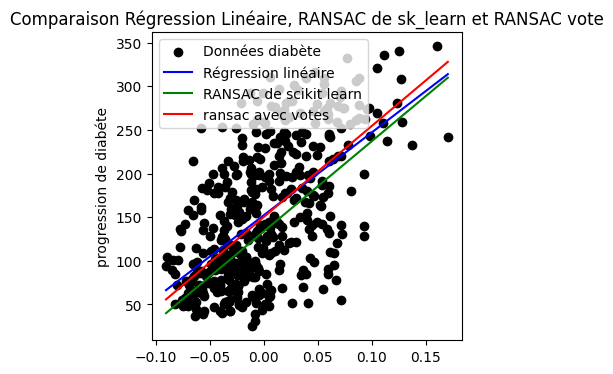

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression, RANSACRegressor

diabetes = datasets.load_diabetes()
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

#cette fonction c'est ransac avec vote , les modéles votent pour les inliers 
def ransac_votes(X, y, n, k, t, q):

    #q: c'est les point les plus votés pour avoir le modéle final

    #initialiser un tab de votes à 0
    vot = np.zeros(len(X))
    model = LinearRegression()
    
    #pour chaque sous ensemble on sélectionne n point aléatoirement 
    for _ in range(k):
        i = np.random.choice(len(X), n, replace=False)
        inlier_x = X[i]
        inlier_y = y[i]
        model.fit(inlier_x, inlier_y)
        

        #si l'erreur est inférieure au seuil t donc elle recoit un vote 
        for j in range(len(X)):
            if np.abs(y[j] - model.predict(X[j].reshape(1, -1))) < t:
                vot[j] += 1
    
    #ensuite on sélectionne les point les plus votés
    num = int(q * len(X))
    ind = np.argsort(vot)[-num:]
    final_x = X[ind]
    final_y = y[ind]
    model.fit(final_x, final_y)
    
    return model, vot

ransac_model, vot = ransac_votes(X, y, n=20, k=100, t=10, q=0.75)

#appliquer les 3 modéles et comparer 
lin_reg = LinearRegression()
lin_reg.fit(X, y)

ransac_sklearn = RANSACRegressor()
ransac_sklearn.fit(X, y)

choix_x = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X1 = lin_reg.predict(choix_x)
X2 = ransac_sklearn.predict(choix_x)
X3 = ransac_model.predict(choix_x)

plt.figure(figsize=(4, 4))
plt.scatter(X, y, color='black', marker='o', label='Données diabète')
plt.plot(choix_x, X1, color='blue', label='Régression linéaire')
plt.plot(choix_x, X2, color='green', label='RANSAC de scikit learn')
plt.plot(choix_x, X3, color='red', label='ransac avec votes')
plt.legend()
plt.title('Comparaison Régression Linéaire, RANSAC de sk_learn et RANSAC vote')
plt.ylabel('progression de diabéte')
plt.show()


**Analyse de ransac avec vote**: 

on remarque que la version de ransac donne des résultats très proches de l'algorithme régression linéaire ce qui prouve que cette version et plus fiable pour détecter les outliers.

**c1)** dans cette partie on vas implémenté RANSAC pour sélectionner le centre le plus représentatif des inliers dans un ensemble de données.

ce programme permet d'estimer la moyenne des inliers dans l'ensemble de données

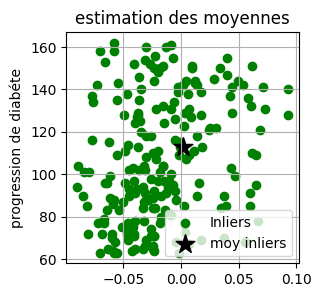

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

diabetes = datasets.load_diabetes()
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

#cette version de ransac permet d'estimer la moyenne des inliers dans un nuage de points
#on recherche les point les plus proches 
def ransac3(X, y, n, num, t):

    #num : nombre d'iteration 
    #t : seuil de distance pour qu'un poit sera considéré comme inlier
    meil_inlier = None
    cpt = 0
    moy_x = None
    moy_y = None
    
    #sélectionner aléatoirement n point
    for _ in range(num):
        ind = np.random.choice(len(X), n, replace=False)
        pt_x = X[ind]
        pt_y = y[ind]
        
        #calcul de la moyenne 
        x_selct = np.mean(pt_x, axis=0)
        y_selct = np.mean(pt_y, axis=0)
        
        dist = np.abs(y - y_selct)
        
        #si la distance est inférieure au seuil t le point est considéré inlier
        inliers = dist < t
        cpt2 = np.sum(inliers)
        
        #on vérifie si l'ensemble d'inliers trouvé contient plus de 
        # points que celui de l'itération précédente donc cet ensemble est meilleur
        if cpt2 > cpt:
            meil_inlier = inliers
            cpt = cpt2
            moy_x = x_selct
            moy_y = y_selct
    
    inliers_X = X[meil_inlier]
    inliers_y = y[meil_inlier]
    
    return inliers_X, inliers_y, moy_x, moy_y

n = 20
num = 100
t = 50

inliers_X, inliers_y, moy_inlx, moy_inl_y = ransac3(X, y, n, num, t)

x1 = np.mean(X)
y1 = np.mean(y)

plt.figure(figsize=(3, 3))
plt.scatter(inliers_X, inliers_y, color='green', label='Inliers', marker='o')


plt.scatter(moy_inlx, moy_inl_y, color='black', marker='*', s=200, label='moy inliers')

plt.title('estimation des moyennes')
plt.xlabel('')
plt.ylabel('progression de diabéte')
plt.legend()
plt.grid(True)
plt.show()


**Interprétation du graphe**:

On observe que L'algorithme RANSAC a détecté les points qui sont proches de la moyenne estimée. Ces points sont considérés comme des inliers

L'étoile noire représente la moyenne des points inliers et l'algorithme RANSAC a exclu les points qui étaient trop éloignés (outliers).

**c2)** dans cette partie on applique Ransac avec regroupement des données en k cluster à l'aide d'une méthode de clustering basée sur des centroïdes, comme 
k-means.


Le code commence par appliquer RANSAC pour identifier les inliers et éliminer les outliers en échantillonnant les données et en vérifiant les distances aux moyennes.

Ensuite, il utilise k-means sur les inliers pour regrouper ces points en k clusters, en ajustant les centroïdes. 

* utilisation de k_means : [k-means](https://scikit-learn.org/stable/modules/clustering.html#k-means)


est un algorithme de clustering ( classification non supervisée) qui regroupe des données en un nombre de clusters k , il est utilisé pour sa simplicité et son efficacité sur de grands ensembles de données .




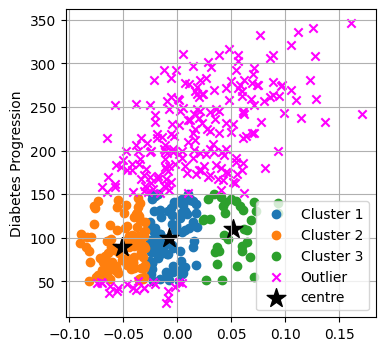

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans

#j'ai utilisé une caractéristique de x pour simplifier 
diabetes = datasets.load_diabetes()
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# elle filtre les inliners puis applique clustering k_means pour diviser en plusieurs clusters 
def ransac_cluster(X, y, n, num, t, cluster):

    #cluster: nbr de cluster à avoir avec k_means
    meil_inlier = None
    cpt = 0
    
    # selectionne des sous ensembles aléatoire 
    for _ in range(num):
        ind = np.random.choice(len(X), n, replace=False)
        pt_x = X[ind]
        pt_y = y[ind]
        
        moy_y = np.mean(pt_y, axis=0)
        dis = np.abs(y - moy_y)
        inliers = dis < t
        cpt2 = np.sum(inliers)
        
        if cpt2 > cpt:
            meil_inlier = inliers
            cpt = cpt2
    
    # on a des inliers et outliers 
    inliers_X = X[meil_inlier]
    inliers_y = y[meil_inlier]
    outliers_X = X[~meil_inlier]
    outliers_y = y[~meil_inlier]
    
    #quand on identifie les inliers avec ransac on applique k_means pour diviser en plusieurs groupes 
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    clusters = kmeans.fit_predict(inliers_X)
    
    return inliers_X, inliers_y, outliers_X, outliers_y, clusters, kmeans.cluster_centers_

n = 20
num = 100
t = 50
cluster = 3

#j'éxecute ransac pour avoir les inliers et outliers ensuite j'applique k-mens 
#pour crééer 3 cluster 

inliers_X, inliers_y, outliers_X, outliers_y, clusters, centre = ransac_cluster(X, y, n, num, t, cluster)

#ici je calcule la moy des y pour chaque cluster afin de trouver les centroides
centre_y = []
for c in range(cluster):
    val = np.mean(inliers_y[clusters == c])
    centre_y.append(val)
centre_y = np.array(centre_y)

plt.figure(figsize=(4, 4))

for cluster in range(cluster):
    clstr_pt = inliers_X[clusters == cluster]
    plt.scatter(clstr_pt, inliers_y[clusters == cluster], label=f'Cluster {cluster + 1}')

plt.scatter(outliers_X, outliers_y, color='magenta', label='Outlier', marker='x')
plt.scatter(centre, centre_y, color='black', marker='*', s=200, label='centre')

plt.title('')
plt.xlabel('')
plt.ylabel('Diabetes Progression')
plt.legend()
plt.grid(True)
plt.show()


**c3)** Ce pseudocode abstrait exprime la généralisation de RANSAC à des problèmes d'estimation ou d'apprentissage statistique arbitraires:

**Initialiser les parametres :**

* max_iter: nbr max d'itération 

* min_inlier : nbr minimum des inliers pour prendre le modèle

* t : seuil d'erreur pour définir un inlier

* meilleur_model = null

**Pour chaque itération de 1 à max_iter**

* Sélectionner un sous-ensemble aléatoire de points de données.

* Ajuster un modèle basé sur les points sélectionnés.

* Calculer les erreurs pour chaque point de données par rapport au modèle ajusté.

* Identifier inliers (erreur < t).

* Si le nombre d'inliers > compteur des inliers :Mettre à jour le meilleur_model avec le modèle actuel.

* Retourner le meilleur modéle 

 

## Partie 2

Dans cette partie du projet, on étudie les effets de la **malédiction de la dimension** tels qu’ils sont présentés dans la **Section 2.5** du livre **The Elements of Statistical Learning** de **Hastie**, **Tibshirani** et **Friedman**. On analyse les idées principales développées dans cette section, puis on met en place le code nécessaire pour **reproduire** et **vérifier expérimentalement** les résultats illustrés dans les **Figures 2.6, 2.7, 2.8 et 2.9**.
Cette étude permet d’observer comment l’augmentation de la **dimension des données** influence la dispersion, la distance entre les points, la densité locale et, plus largement, le comportement des méthodes d’apprentissage statistique dans des espaces de grande dimension.



## Solution : 

* le but est de reproduire les expériences illustrées dans les figures données dans le livre :

* figure 2.6: représente le pourcentage de volume capturé en fonction de la distance dans un cube pour diverses mesures p.

On remarque que plus la dimension p augmente, plus il faut parcourir une grande distance pour capturer le même volume , ce qui entraîne la dispersion croissante des données dans des espaces de grande dimension.

$e_p(r)$ est la longueur de l'arête du sous-cube nécessaire pour capturer une fraction $r$ du volume des données dans un p-dimensional unit hypercube, il est donné par la formule suivante : $$ e_p(r) = r^{\frac{1}{p}} $$




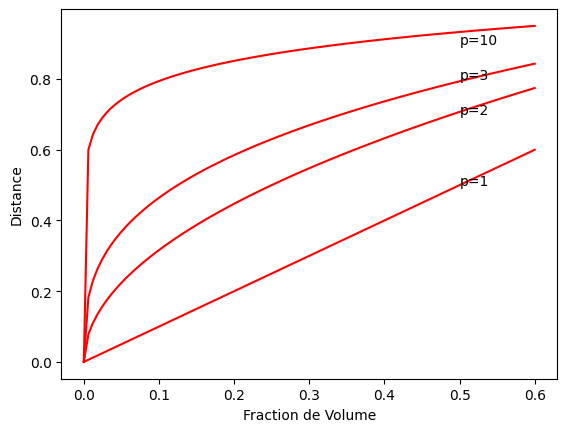

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#initialiser la dimension et la fraction de volume
dim = [1, 2, 3, 10] 
r = np.linspace(0, 0.6, 100) 

#la fonction qui represente la longeur l'arete du sous cube en fonction de r et p 
def longeur(r, p):
    return r**(1/p)

#boucle pour plote de la distance en fonction de r
for p in dim:
    e_p = longeur(r, p)
    plt.plot(r, e_p, label=f'p={p}', color='red')

plt.xlabel('Fraction de Volume')
plt.ylabel('Distance')

for p, pos in zip([1, 2, 3, 10], [0.5, 0.7, 0.8, 0.9]):
    plt.text(0.5,pos, f'p={p}')

plt.show()



**Interprétation de la figure :**

Cette figure montre l'évolution de la distance nécessaire pour capturer une fraction donnée du volume de données dans un espace de dimension p.

On voit que dans des espaces de plus faible dimension (p=1, p=2), il suffit d'une petite distance pour capturer une bonne fraction. Mais  dans des espaces de dimension plus élevée (p=10), il faut une grande distance pour capturer le même pourcentage de données.

Dans les espaces à haute dimension,  knn est inefficace, car on doit explorer une très grande partie de l'espace pour capturer une petite fraction des données.



* Figure 2.7 : contient 3 courbes :

1- Dimension en fonction de la distance au plus proche voisin : Ce graphe montre que la distance moyenne au plus proche voisin augmente avec la dimension, ce qui montre la dispersion croissante des points dans des espaces de grande dimension.

2- Dimension en fonction de l'erreur quadratique moyenne (MSE): Ce graphe montre l'évolution de l'erreur quadratique moyenne (MSE), du biais et de la variance en fonction de la dimension. On remarque que le biais carré augmente rapidement avec la dimension, tandis que la variance reste faible, ce qui cause une augmentation du MSE.

3- la fonction F(x) : ce graphe représente f(x) centré en 0.

Le code implémenté simule un problème où un modèle de 1-nearest neighbor (1-NN) est utilisé pour prédire la valeur de la fonction $ f(X) = e^{-8 ||X||^2} $ et le but est de calculer et d'afficher comment la distance au plus proche voisin, la variance, le biais et l'erreur quadratique moyenne (MSE) évoluent en fonction de la dimension de l'espace.

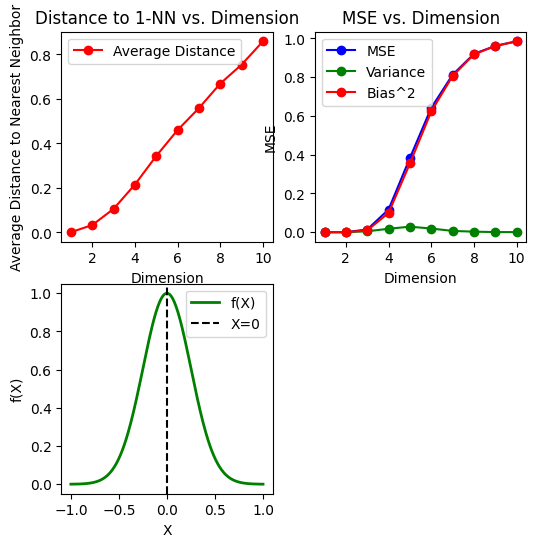

In [16]:
import numpy as np
import matplotlib.pyplot as plt


# la fonction calcule f(X) = exp(-8 * ||X||^2) pour chaque point 
def fct(X):
    return np.exp(-8 * np.linalg.norm(X, axis=1)**2)

dim = np.arange(1, 11)
train = 1000
n = 100
x_test = np.zeros(1)

#pour stocker les résultat de mse et variance et bias et distance
mse = []
variance = []
bias = []
distance = [] 

# pour chaque dimension de 1 à 10 
for p in dim:
    mse_rep = []
    pred = []
    d = [] 
    
    #répeter n fois pour obtenir des moy stables 
    for _ in range(n):
       
        X_train = np.random.uniform(-1, 1, (train, p))
        y_train = fct(X_train)

        #calculer les distances de chaque point a x_test= 0
        dis = np.linalg.norm(X_train - x_test, axis=1)
        #ensuite trouver ind du plus proche voisin et prédiction 
        near = np.argmin(dis)
        y_pred = y_train[near]
        pred.append(y_pred)

        d.append(dis[near])

    pred = np.array(pred)
    d = np.array(d)

    # j'ai calculé le bias au carré 
    bias_sq = (np.mean(pred) - fct(x_test.reshape(1, -1)))**2
    bias.append(bias_sq)
    
    #calcul de la variance des prédiction 
    var = np.var(pred)
    variance.append(var)
    
    #mse= biai carré + variance
    mse_val = bias_sq + var
    mse.append(mse_val)
    
    #jai calculé la distance moyenne au plus proche voisin
    distance.append(np.mean(d))

#convertir pour les tracés
mse = np.array(mse)
variance = np.array(variance)
bias = np.array(bias)
distance = np.array(distance)

plt.figure(figsize=(6, 6))

# ce graphe affiche la distance moyenne au plus proche voisin en fonction de la dimension 
plt.subplot(2, 2, 1)
plt.plot(dim, distance, 'ro-', label='Average Distance')
plt.title('Distance to 1-NN vs. Dimension')
plt.xlabel('Dimension')
plt.ylabel('Average Distance to Nearest Neighbor')
plt.legend()

# ce graphe affiche mse, variance et biais eu carré en fonction de la dimension 
plt.subplot(2, 2, 2)
plt.plot(dim, mse, 'bo-', label='MSE')
plt.plot(dim, variance, 'go-', label='Variance')
plt.plot(dim, bias, 'ro-', label='Bias^2')
plt.title('MSE vs. Dimension')
plt.xlabel('Dimension')
plt.ylabel('MSE')
plt.legend()

#pour ploter la courbe de f(x)
x = np.linspace(-1, 1, 200).reshape(-1, 1)  
y = fct(x)

plt.subplot(2, 2, 3)

plt.plot(x, y, 'g-', label='f(X)', lw=2) 
plt.xlabel('X')
plt.ylabel('f(X)')
plt.axvline(0, color='black', linestyle='--', label='X=0')
plt.legend()
plt.show()

* Interprétation des graphes :

**mse** : L'erreur quadratique moyenne augmente quand la dimension augmente, à partir de la dimension 4, elle augmente fortement pour atteindre 1 pour des dimensions élevées.

**Biais au carré** :  Le biais au carré augmente rapidement avec la dimension. 

**Variance** :  La variance reste presque constante et faible, ce qui montre que la variabilité des prédictions autour de leur moyenne est faible.

Dans des espaces de haute dimension, la distance au plus proche voisin devient beaucoup plus grande, ce qui augmente le biais du modèle et cause l'augmentation de la MSE.

**la figure 2.8 : représente 2 courbes :**

1- dimension en fonction du MSE :Ce graphe montre l'évolution de l'erreur quadratique moyenne (MSE), de la variance et du biais carré en fonction de la dimension. 

2- La figure représente la fonction $f(X) = 0.5 \times (X + 1)^3$ utilisé pour générer les valeurs en une dimension.

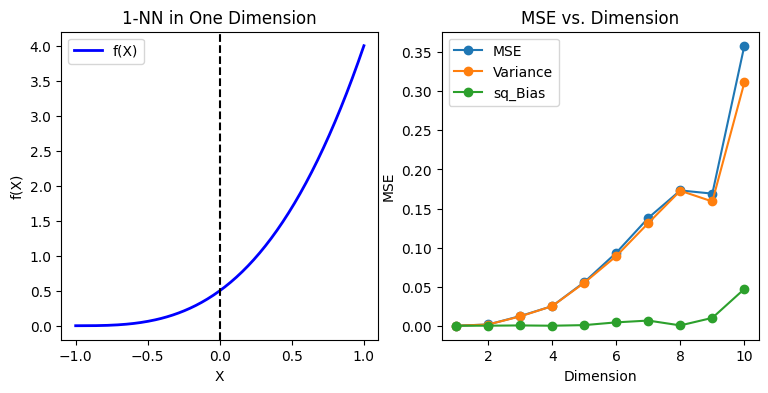

In [17]:
import numpy as np
import matplotlib.pyplot as plt

#j'initialise la dimension, nbr d'entainement et n
dim = np.arange(1, 11)
train = 1000
n = 100
x_test = np.zeros(1) 

#implementer la fct avec la première dimension X[:, 0]
def fct(X):
    return 0.5 * (X[:, 0] + 1) ** 3

mse = []
variance = []
bias = []

#parcourir les dimension de 1 à 10 
for p in dim:
    mse_rep = []
    pred = []

    for _ in range(n):
        
        #générer les données d'entainement 
        X_train = np.random.uniform(-1, 1, (train, p))
        y_train = fct(X_train)
        
        #calculer les distances 
        dis = np.linalg.norm(X_train - x_test, axis=1)
        near = np.argmin(dis)
        y_pred = y_train[near]
        pred.append(y_pred)

    #calculer le biais au carré et la variance et mse 
    pred = np.array(pred)
    bias_sq = (np.mean(pred) - fct(x_test.reshape(1, -1)))**2
    var = np.var(pred)
    mse_val = bias_sq + var
    
    bias.append(bias_sq)
    variance.append(var)
    mse.append(mse_val)

#pour ploter la f(x)
x = np.linspace(-1, 1, 200).reshape(-1, 1)
y = fct(x)

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y, 'b-', label='f(X)', lw=2)
plt.axvline(0, color='black', linestyle='--')
plt.title('1-NN in One Dimension')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()

#graphe qui affiche mse variance et biais au carré en fonction de la dimension
plt.subplot(1, 2, 2)
plt.plot(dim, mse, label='MSE', marker='o')
plt.plot(dim, variance, label='Variance', marker='o')
plt.plot(dim, bias, label='sq_Bias', marker='o')
plt.xlabel('Dimension')
plt.ylabel('MSE')
plt.title('MSE vs. Dimension')
plt.legend()

plt.show()



**Interprétation du graphe** :

**mse (Erreur quadratique moyenne)**: La MSE augmente à partir de la dimension 6, ce qui prouve les erreurs de prédiction augmentent lorsque la dimension augmente.

**Variance** :la variance augmente quand la dimension augmente, ce qui contribue à l'augmentation des erreurs.

**Biais au carré**: le biais reste faible.

On observe que, comme la dimension augmente, le biais carré reste faible alors que la variance et la MSE augmentent rapidement, ce qui cause une difficulté croissante de la prédiction dans des espaces de haute dimension.



* Figure 2.9 : 

cette figure représente le rapport de l'erreur de prédiction espérée (EPE) entre la méthode des k plus proches voisins (1NN) et moindres carrés ordinaires (OLS) en fonction de la dimension, pour le modéle linéaire et cubique :

* $f_1(x) = x$ : un modèle linéaire simple.
* $f_2(x) = \frac{1}{2} (x + 1)^3$ : un modèle cubique.




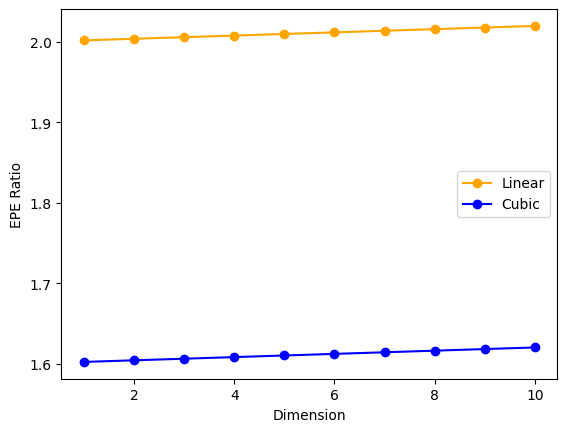

In [18]:
import numpy as np
import matplotlib.pyplot as plt

#initialiser la taille et la dimension et l'ecart type
N = 500
dim = np.arange(1, 11)
sigma = 1

#1 ere fonction 
def f1(x):
    return x

#2 eme fonction 
def f2(x):
    return 0.5 * (x + 1)**3

# génerer des données aléatoires
x = np.random.uniform(-1, 1, N)
epsilon= np.random.normal(0, 1, N)

#calcul des valeurs pour le modéle linéaire et cubique 
y_lin = f1(x) + epsilon
y_cubic = f2(x) + epsilon

#fonction pour calculer l'erreur EPE pour le modèle linéaire
def epe1(dim):
    epe1 = []
    for p in dim:
        epe = 2 + sigma * (p / N) 
        epe1.append(epe)
    return epe1
    
#fonction pour calculer l'erreur EPE pour le modèle cubique 
def epe2(dim):
    epe2 = []
    for p in dim:
        epe = 1.6 + sigma * (p / N) 
        epe2.append(epe)
    return epe2
 

epelin = epe1(dim)
epecubic = epe2(dim)

#avoir les graphe de EPE en fonction de la dimension
plt.plot(dim, epelin, marker='o',color='orange', label='Linear')
plt.plot(dim, epecubic, marker='o',color='blue', label='Cubic')
plt.xlabel('Dimension')
plt.ylabel('EPE Ratio')
plt.legend()
plt.show()


**Intérprétation du graphe** : 

**Modèle linéaire**: 

EPE reste autour de 2 et augmente légèrement avec la dimension ce qui montre que la méthode OLS des moindres carrés a une performance plus constante pour le modèle linéaire à des dimensions plus élevées.

**Modèle cubique** :

EPE pour le modèle cubique commence à 1,6, ce qui montre que OLS présente un biais à faible dimension et 1NN devient moins performant quand la dimension augmente.



## Partie 3


Dans cette partie du travail, on s’intéresse au choix du **ratio train/test** et à la manière dont il influence les performances d’un modèle de classification. L’objectif est d’évaluer empiriquement la règle générale qui recommande un ratio de séparation **significativement supérieur à 1**, par exemple un partage **75%–25%**. Pour cela, on sélectionne un **jeu de données de classification** et on applique une **méthode de classification adaptée**, c’est-à-dire capable d’obtenir des performances raisonnables sur ce dataset. On teste ensuite plusieurs valeurs de ratio en faisant varier la proportion d’entraînement et de test, typiquement de **0% à 100%** avec un pas régulier. Des **courbes de performance** sont produites afin de visualiser l’évolution de l’efficacité du modèle selon le ratio choisi.
L’analyse de ces résultats permet de justifier le comportement observé à l’aide d’arguments théoriques, notamment ceux liés au **compromis biais-variance**. On identifie également le **meilleur ratio** pour le cas étudié. Enfin, on introduit une séparation **train/validation/test**, ce qui permet d’optimiser les **hyperparamètres** du modèle et d’obtenir la **version finale entraînée**, celle qui serait retenue pour une utilisation pratique.

Dans un second volet, on étudie le principe de la **cross-validation**, qui consiste à diviser les données en plusieurs parties **non superposées** afin d’entraîner et d’évaluer un modèle de manière répétée sur des sous-ensembles distincts. Les deux configurations habituelles sont :
– la **séparation simple train/test**,
– la **validation croisée en k-folds**.
On se place dans un contexte particulier : la validation d’un modèle de **régression pour séries temporelles** (**time-series forecasting**), où il est essentiel de **respecter l’ordre temporel** des données. Une procédure spécifique est donc conçue pour adapter ces deux formes de validation à la nature séquentielle du problème. On décrit enfin un **pseudocode** qui explique comment appliquer correctement ces deux approches tout en respectant la dimension temporelle des données.


## Solution : 

**a)** Dans cette partie on a pour objectif de valider empiriquement le choix du ratio train/test pour la classification ensuite optimisation des hyperparamétres à l'aide d'une séparation train/validation/test.

partie 1: Validation du ratio train/test :

* Choix du dataset: Iris qui est un ensemble de données classique pour les tâches de classification,il est divisés en trois classes.

* Choix de l'algorithme de classification: K-NN qui sert à classer un point en fonction de ses "k" voisins les plus proches

* ratio :j'ai pris des ratios de 0.05 à 0.95 par pas de 0.05 (tester plusieurs tailles en allant de 5% à 95% des données)

On vas visualiser les performances sous forme de graphe qui permet d'analyser comment le ratio affecte la précision du modèle, ce qui permet de trouver le meilleur ratio en termes de performances pour le modèle k-NN sur le dataset Iris


Le meilleur ratio 0.70 avec une précision de 1.00


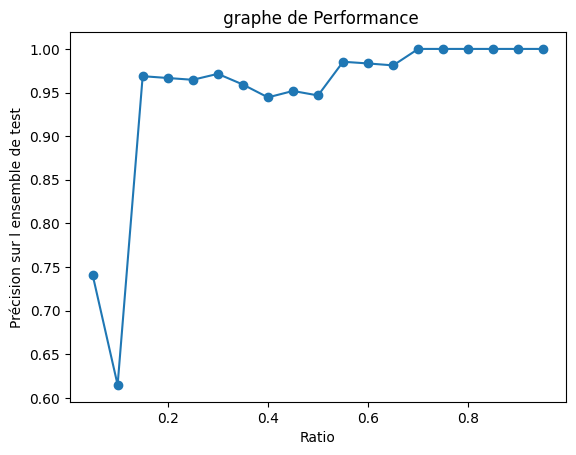

In [19]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

#j'ai utilisé data iris 
iris = load_iris()
X = iris.data
y = iris.target

#utiliser knn avec 5 voisins pour la classification 
knn = KNeighborsClassifier(n_neighbors=5)

#tester plusieurs ratio 
ratio= np.arange(0.05, 1.0, 0.05)
perf= []

for r in ratio:
    #séparer les données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-r, random_state=42)

    #entrainer avec knn 
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    #calculer accuracy
    accuracy = accuracy_score(y_test, y_pred)
    perf.append(accuracy)

ind = np.argmax(perf)
meil_ratio = ratio[ind]
meil_perf = perf[ind]

# Afficher les résultats du meuilleur ratio et sa précision 
print(f"Le meilleur ratio {meil_ratio:.2f} avec une précision de {meil_perf:.2f}")

#afficher le graphe qui represente la précison en fonction du ratio
plt.plot(ratio, perf, marker='o')
plt.title(' graphe de Performance')
plt.xlabel('Ratio')
plt.ylabel('Précision sur l ensemble de test')
plt.show()



Analyse du graphe :

Ce graphe représente la précision du modèle de classification KNN sur l'ensemble de test en fonction du ratio de données

* En dessous de 0.2, la performance chute à cause du manque de données pour un apprentissage efficace

* la précision augmente rapidement à partir d'un ratio de 0.2 et atteint une performance optimale autour de 0.7, avec une précision proche de 1.0, indiquant qu'un ratio d'entraînement de 70% est idéal pour obtenir des performances maximales


Optimisation des hyperparamétres:


* Division des données en ensembles d'entraînement, de validation et de test
* Recherche des meilleurs hyperparamètres k
* Validation croisée (Cross-validation) pour chaque k



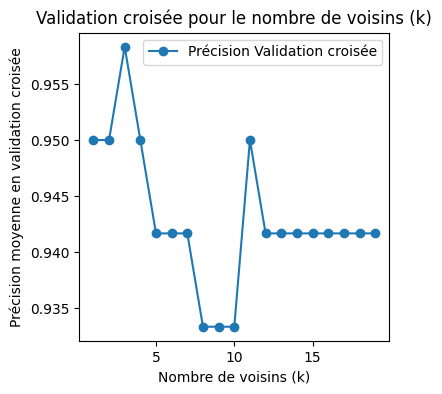

Le meilleur k trouvé est 3
Précision finale  1.00


In [21]:
#optimisation des paramétres 

# On va diviser en train, validation, test
X_train1, X_test, y_tain1, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_tain1, test_size=0.2, random_state=42)  
# 20% de l'ensemble d'entraînement pour la validation

#prendre une plage de valeur de k 
K = np.arange(1, 20)
scr = []


for k in K:

    #utiliser une validation croisée à 5 plis et calculer accuracy 
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train1, y_tain1, cv=5, scoring='accuracy')
    scr.append(np.mean(scores))


plt.figure(figsize=(4, 4))
plt.plot(K, scr, marker='o', label="Précision Validation croisée")
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Précision moyenne en validation croisée')
plt.title('Validation croisée pour le nombre de voisins (k)')
plt.legend()
plt.show()

# Trouver le meilleur k 
meil_k = K[np.argmax(scr)]
print(f"Le meilleur k trouvé est {meil_k}")

# Entraîner le modèle final avec le meilleur k
KNN = KNeighborsClassifier(n_neighbors=meil_k)
KNN.fit(X_train1, y_tain1)
y_test_pred_cv = KNN.predict(X_test)
ACC_final = accuracy_score(y_test, y_test_pred_cv)
print(f"Précision finale  {ACC_final:.2f}")



Analyse du graphe: 

* Le graphe montre la précision moyenne en validation croisée en fonction du nombre de voisins k

* Il montre que la précision la plus élevée est obtenue pour k=3 

et lorsque k est trop grand la précision diminue car le biais augmente  


**b)** La validation croisée consiste à diviser l'ensemble de données en segments distincts, puis à entraîner et évaluer les performances d'une méthode 

**i)** algo1: division train test

* Divisez les données : les données les plus anciennes sont affectées à l'ensemble d'apprentissage et les plus récentes à l'ensemble de test
* Entraînez le modèle sur l'ensemble d'apprentissage

* tester le modèle sur l'ensemble de test (données plus récentes)

* Évaluer la performance du modèle en fonction de la précision

**ii)** algo2: approche en k-fold

* Divisez les données en k folds
* Pour chaque pli :
    * Utilisez les plis les plus anciens pour l'entraînement.
    * Utilisez le pli suivant pour la validation (données plus récentes).

* Entraîner le modèle sur l'ensemble d'apprentissage de chaque pli et tester le modèle sur l'ensemble de validation pour chaque pli

* Répéter le processus pour tous les plis.

* Évaluer la performance


## Partie 4

Dans cette partie du projet, on étudie l’application de la **classification linéaire** dans un contexte particulier : celui du **stream processing**, où les données arrivent de manière séquentielle. À chaque instant $( t )$, on reçoit une paire d’observations composée d’un élément de la **classe A** et d’un élément de la **classe B**. Comme on ne peut pas stocker l’ensemble du flux pour effectuer un traitement en lot, l’objectif est de concevoir une **méthode d’apprentissage en ligne frugale**, capable de mettre à jour un **modèle linéaire** ( \text{model}_t ) en utilisant uniquement les informations essentielles. Ce modèle doit rester fonctionnel en continu et être capable, à tout moment, de **classer des données inconnues**.

On commence par analyser précisément les **contraintes du contexte streaming**, puis on propose un mécanisme permettant de maintenir et mettre à jour un modèle linéaire fondé sur les données successives. On explique les raisons pour lesquelles cette approche est correcte et on évalue la **mémoire minimale** nécessaire pour qu’elle puisse fonctionner de manière efficace.

Dans un second temps, on applique cette stratégie à un ensemble de données générées à partir de deux **distributions gaussiennes 2D**, chacune contenant ( n ) observations, pour un total ( N = n + n ). Les deux distributions partagent la même **déviation standard**, mais possèdent des **moyennes distinctes** $( \mu_1 )$ et $( \mu_2 )$. En utilisant un grand nombre d’échantillons (par exemple **500 observations par classe**), on observe l’évolution des performances du modèle en ligne $( \text{model}_t )$ au cours du temps, pour $( t = 1, \dots, N )$, à l’aide d’un **jeu de test** composé de **500 + 500** points issus des mêmes distributions.
Sur un même graphique, on compare ces performances temporelles à celles d’un **classifieur linéaire entraîné en batch** sur l’ensemble des $( N )$ données, qui apparaît sous forme de ligne horizontale. Plusieurs paires $((\mu_1, \mu_2))$ sont utilisées pour illustrer un **cas facile** et un **cas plus difficile**, permettant d’analyser l’impact du degré de séparabilité des classes sur l’apprentissage en ligne.




## Solution :

L'objectif est de développer un modèle pour classer des données de deux classes, pour cela j'ai utilisé une approche dapprentissage en ligne SGD qui minimise les besoin en mémoire (ce modéle est capable de classifier les données).


* SGD: Stochastic Gradient Descent, est un algorithme d'optimisation utilisé pour minimiser une fonction de coût dans des modèles d'apprentissage automatique, il met à jour les paramètres du modèle après chaque observation ce qui permet un apprentissage plus rapide avec moins de mémoire(reférence SGD)[https://scikit-learn.org/stable/modules/sgd.html]

Etape suivie pour générer mon code :

* La fonction "gen_donnes" génere des données pour A et B avec des moyenne et un ecart type (créer deux ensembles de points pour la classification)

* À chaque itération une paire de points est utilisée pour mettre à jour le modèle avec la méthode de descente de gradient stochastique (SGD), grâce à la méthode partial_fit

* Après chaque mise à jour, la précision du modèle est calculée.

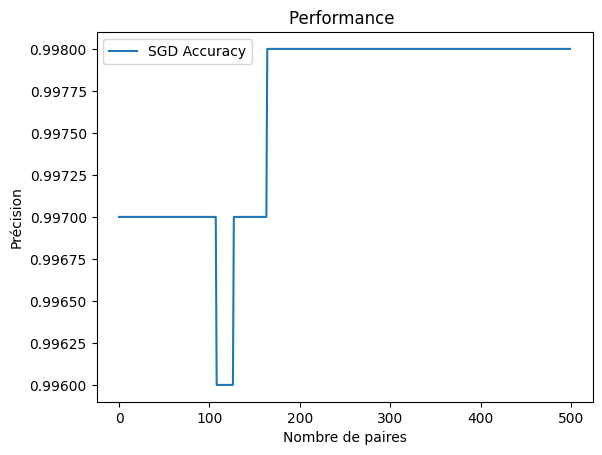

In [37]:
import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

#cette fonction est pour génerer des données
def gen_donnes(n, mu1, mu2, sigma=1.0):

    #n: nbr d'echantillons 
    #mu1 et mu2 sont les moyenne des distribution des classe A et B
    #sigme cest l'ecart type 

    #génerer des points pour A et B avec distribution normale
    A = np.random.normal(mu1, sigma, (n, 2))
    B = np.random.normal(mu2, sigma, (n, 2))
    return A, B

n = 500
mu1 = [2, 2]
mu2 = [-2, -2]

#génerer des données pour A et B
A, B = gen_donnes(n, mu1, mu2)

#les étiquettes pour A et B
etiqetteA = np.ones(n)
etiqetteB = np.zeros(n)

#combiner les etiquettes et les données 
X = np.vstack((A, B))
y = np.hstack((etiqetteA, etiqetteB))

#utiliser le classificateur SGD (Stochastic Gradient Descent)
sgd = SGDClassifier()

# génerer les données de test
A_test, B_test = gen_donnes(n, mu1, mu2)
X_test = np.vstack((A_test, B_test))
y_test = np.hstack((np.ones(n), np.zeros(n)))

#pour stocker les accuracy
ACC = []

for i in range(n):

    #a chaque itération sélectionner une pair d'echantillons
    X1 = np.vstack((A[i], B[i]))
    Y2 = np.array([1, 0])
    sgd.partial_fit(X1, Y2, classes=[0, 1])

    #calculer la accuracy pour évaluer les performances 
    accuracy = sgd.score(X_test, y_test)
    ACC.append(accuracy)

#utiliser SGD
model = SGDClassifier()
model.fit(X, y)
accur = model.score(X_test, y_test)

plt.plot(range(n), ACC, label='SGD Accuracy')
plt.xlabel('Nombre de paires')
plt.ylabel('Précision')
plt.title('Performance ')
plt.legend()
plt.show()


Ce graphe montre l'évolution de la précision du modèle SGD en fonction du nombre de paires de données.

On observe après environ 200 paires la précision reste stable et élevée ce qui prouve que le modèle s'adapte bien aux données au fur et à mesure qu'elles arrivent.


## Partie 5

Dans cette partie du projet, on cherche à définir une mesure permettant d’évaluer la **régularité** du comportement d’un classifieur, en s’appuyant sur l’hypothèse centrale selon laquelle un problème d’apprentissage doit présenter une certaine **continuité** ou **régularité locale** dans l’espace des données. L’idée est de proposer une mesure inspirée du principe des **plus proches voisins**, capable d’analyser la cohérence des décisions d’un modèle au sein du domaine considéré. La fonction conçue, notée **Regularity(X, Y, …)**, doit quantifier dans quelle mesure un classifieur produit des décisions régulières autour de chaque point.

Afin d’étudier le comportement de cette mesure, on génère des données issues d’un **mélange de deux distributions gaussiennes**, puis on observe l’évolution de la **Regularity** et de l’**Accuracy** traditionnelles en fonction de plusieurs facteurs clés :

– la **taille du jeu de données**, en faisant varier le nombre d’objets par classe ;

– la **dimension** des données, testée sur un ensemble de valeurs croissantes ;

– le **chevauchement** entre les classes, contrôlé par la distance (\delta) entre leurs moyennes ;

– le paramètre d’entrée **k**, qui régule la portée locale pour l’évaluation de la régularité.

Pour chaque combinaison de paramètres, on répète plusieurs expériences, on entraîne un **classifieur kNN** ainsi qu’un **arbre de décision** (avec une profondeur adaptée), puis on évalue leurs performances à la fois en termes d’Accuracy et de Regularity. Ces analyses sont réalisées **avec et sans validation croisée** en 10 plis, afin de mieux comprendre l’impact de l’échantillonnage sur les conclusions.

Enfin, on aborde plusieurs questions conceptuelles :
On discute d’abord la différence entre un **classifieur kNN** et un **radius-NN**, ce dernier sélectionnant tous les points dans un rayon donné plutôt qu’un nombre fixe de voisins. On identifie dans quels contextes l’un ou l’autre est plus pertinent, et comment la définition de la mesure Regularity devrait être **adaptée** si un radius-NN était utilisé à la place du kNN classique.
On explore ensuite comment cette mesure devrait être modifiée dans le cadre d’un **problème de régression**, où la cohérence locale ne concerne plus des étiquettes discrètes mais des valeurs continues. Dans ce cas, la régularité doit être pensée en termes de **variation lisse** des prédictions dans le voisinage des points.



## Solution  : 

Les étapes suivie : 

* implémentation de la fonction régularité qui compare les prédiction d'un modéle a celle de knn 

* Générer des données à partir de deux distributions gaussiennes en fonction des paramètres spécifiés : nombre d'échantillons, dimensionnalité, distance entre les centres des classes (delta), et la covariance (sigma).

* entrainer le modéle et calculer les accuracy et la régularité en utilisant knn et arbre de décision (KNeighborsClassifier) et (DecisionTreeClassifier)

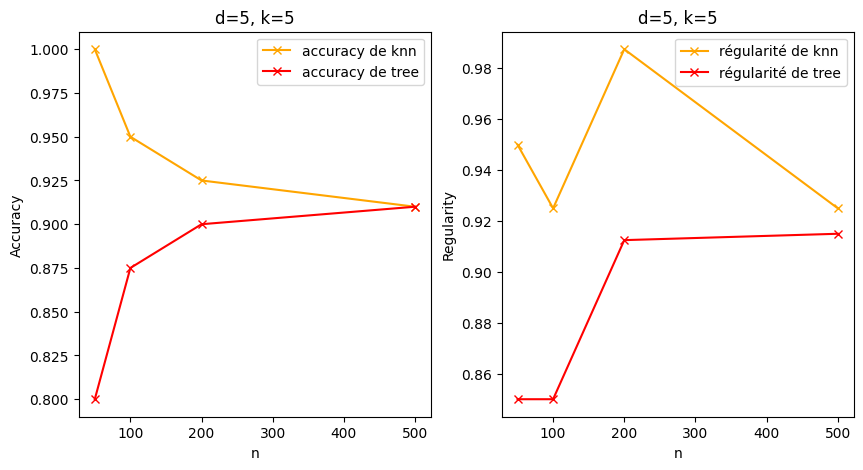

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#fonction pour calculer la régularité d'un modèle de classification
#compare les prédictions de k-NN avec celles du modèle
def regularity(X, y, model):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X, y)
    knn_pred = knn.predict(X)
    val = np.mean(knn_pred == model.predict(X))
    return val

#cette fonction génere des données a partir de 2 distributions gaussiénne 
def gen_donnes(n, d, delta, sigma):

    #génerer les données pour A et B
    mean_A = np.zeros(d)
    mean_B = np.ones(d) * delta
    cov = np.eye(d) * sigma
    A = np.random.multivariate_normal(mean_A, cov, n)
    B = np.random.multivariate_normal(mean_B, cov, n)
    X = np.vstack((A, B))
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

#initialialiser pour utiliser 
N = [50, 100, 200, 500]
D = [1, 2, 5]
dis = [2]
K = [1, 5]

#pour stocker les résultats 
n_i = []
d_i = []
delta_i = []
k_i = []
knn_accur = []
knn_regul = []
tree_accur = []
tree_regul = []

#ici j'ai implémenté le code selon le pseudo code donnée 
for n in N:
    for d in D:
        for delta in dis:
            for k in K:
                #générer des données
                X, y = gen_donnes(n, d, delta, sigma=2)
                #séparer en 20% test et 80% entrainement
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
               
                #utiliser knn avec K voisin ensuite calculer accuracy et la régularité
                knn = KNeighborsClassifier(n_neighbors=k)
                knn.fit(X_train, y_train)
                knn_acc = accuracy_score(y_test, knn.predict(X_test))
                knn_reg = regularity(X_test, y_test, knn)

                #utiliser le modele tree avec profendeur 5 ensuite calculer accuracy et la régularité
                tree = DecisionTreeClassifier(max_depth=5)
                tree.fit(X_train, y_train)
                tree_acc = accuracy_score(y_test, tree.predict(X_test))
                tree_reg = regularity(X_test, y_test, tree)

                #stocker les résultats
                n_i.append(n)
                d_i.append(d)
                delta_i.append(delta)
                k_i.append(k)
                knn_accur.append(knn_acc)
                knn_regul.append(knn_reg)
                tree_accur.append(tree_acc)
                tree_regul.append(tree_reg)


knn_acc = []
tree_acc = []
tab_n = []
knn_reg = []
tree_reg = []

for i in range(len(n_i)):
    if d_i[i] == 5 and k_i[i] == 5:
        tab_n.append(n_i[i])
        knn_acc.append(knn_accur[i])
        tree_acc.append(tree_accur[i])
        knn_reg.append(knn_regul[i])
        tree_reg.append(tree_regul[i])



#le graphe pour comparer les performances des 2 modeles knn et decision tree (calculer accuracy)
plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.plot(tab_n, knn_acc, label='accuracy de knn', marker='x', color='orange')
plt.plot(tab_n, tree_acc, label='accuracy de tree', marker='x', color='red')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.title(f'd=5, k=5')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tab_n, knn_reg, label='régularité de knn', marker='x', color='orange')
plt.plot(tab_n, tree_reg, label='régularité de tree', marker='x', color='red')
plt.xlabel('n')
plt.ylabel('Regularity')
plt.title(f'd=5, k=5')
plt.legend()

plt.show()


Analyse des graphes :

le graphe 1 : représente la précision en fonction de la taille n 
* on vois que le modéle knn commence avec une meilleure précision que l'arbre de décision ensuite sa précision diminue lorsque n augmente 
* par contre pour l'arbre de décision la précision augmente en fonction de la taille de l'echantillon.

le graphe 2: 
* knn montre une bonne régularité au début mais aprés elle baisse.
* l'arbre de décision après 100 échantillons il s'améliore et devient plus régulier avec l'augmentation de la taille de données.

k-NN montre une meilleure performance globale en termes de précision et de régularité au début, et l'arbre de décision montre de meilleurs performances avec l'augmentation des données ce qui peut être du a ce que knn est mieux adapté pour de petites quantités de données, tandis que l'arbre de décision est plus compétitif avec des quantités de données plus grandes.

Réponses au questions:

**1)-** Différence entre k-NN et un classificateur radius-NN (reférence)[https://scikit-learn.org/stable/modules/neighbors.html]

* k-NN (k-nearest neighbors) : Ce classificateur cherche les k plus proches voisins d'un point à classer. Le paramètre utilisé est k (le nombre de voisins).
    * le knn est utile lorsque les données sont uniformément réparties, car il garantit toujours k voisins à considérer pour chaque prédiction, même si certains sont éloignés.

* Radius-NN (radius-nearest neighbors) : Ce classificateur cherche tous les voisins situés dans un certain rayon donné autour d'un point, et non un nombre fixe de voisins. Le paramètre utilisé est le rayon (radius), qui détermine jusqu'où chercher pour trouver les voisins.
    * le radius knn est plus efficace dans des situations où les données peuvent être non uniformément réparties, car il prend en compte uniquement les voisins suffisamment proches (les voisins situés dans un certain rayon).

**2)-** si on utilise le radius-NN à la place de KNN on doit ajuster la mesure de régularité en fonction du nombre de voisins trouvés dans le rayon et tester différents rayons pour observer leur impact sur la précision et la régularité du modèle.

**3)-** Dans un problème de régression, la régularité mesure à quel point les prédictions du modèle sont cohérentes pour des points proches, en comparant leurs valeurs continues. Plutôt que de vérifier les classes comme en classification.



## Partie 6:

Dans cette partie du projet, on applique les méthodes de **régression Ridge** et **régression Lasso** sur le **jeu de données du diabète**, en mettant l’accent sur l’**optimisation du paramètre de régularisation** $( \alpha )$ grâce à la **validation croisée**. L’objectif est de comprendre de manière approfondie comment la **régularisation** modifie le comportement des modèles linéaires et comment le choix d’un bon $( \alpha )$ permet d’améliorer leur **généralisation**.

Pour analyser ces effets, on génère plusieurs **graphes explicatifs**.
Le premier représente l’évolution de l’ensemble des **coefficients** du modèle (le vecteur **$( w )$**) en fonction de la valeur de **$( \alpha )$**, ce qui permet d’observer comment les coefficients sont progressivement réduits lorsque la régularisation augmente, une caractéristique particulièrement marquée pour la **régression Lasso** qui peut annuler certains coefficients.

Un second graphique illustre les **résidus** ainsi que la performance mesurée par le **$score ( R^2 )$**, afin d’évaluer la **qualité d’ajustement** des modèles entraînés. Ces visualisations permettent de comprendre l’équilibre entre complexité du modèle, stabilité des coefficients et performance prédictive, tout en mettant en évidence l’importance d’un choix approprié de **$( \alpha )$** pour obtenir un modèle robuste et performant.





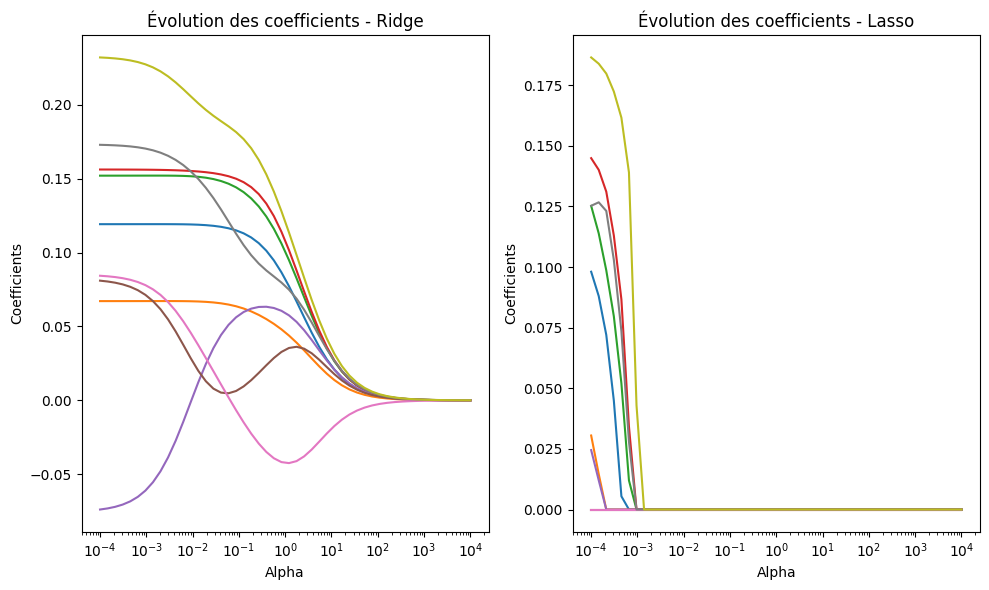

Meilleur alpha de Ridge: 0.2682695795279725
Meilleur alpha de Lasso: 0.0001


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score


diabetes = load_diabetes()
# Utilise toutes les caractéristiques sauf la dernière
X = diabetes.data[:, :-1]

# la 11ème comme cible(progression de la maladie)
y = diabetes.data[:, -1]

# j'ai initialisé des listes pour stocker les résultats
ridge_cof = []
lasso_cof = []
ridge_scr = []
lasso_scr = []
ris1_moy = []
ris2_moy = []

# Définir alpha qui représente le paramétre de régularisation 
alpha = np.logspace(-4, 4, 50)

# Calcul des coefficients et du score R² pour chaque alpha
for a in alpha:
    # Pour Ridge
    # crée un modéle ridge avec les alpha
    ridge = Ridge(alpha=a)
    ridge.fit(X, y)
    ridge_cof.append(ridge.coef_)
    
    #j'ai utilisé la validation croisé avec score R2 et 5 plis
    scr1 = cross_val_score(ridge, X, y, cv=5, scoring='r2')
    #stocker la moy de R2
    ridge_scr.append(np.mean(scr1))
    
    # Validation croisée pour l'erreur absolue moyenne pour mesurer les performances en terme de précision 
    ris1 = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_absolute_error')
    ris1_moy.append(-np.mean(ris1)) 
    
    # Pour Lasso
    # crée un modéle lasso avec les alpha 
    lasso = Lasso(alpha=a)
    lasso.fit(X, y)
    lasso_cof.append(lasso.coef_)
    
    #j'ai utilisé la validation croisé avec score R2 et 5 plis
    scr2 = cross_val_score(lasso, X, y, cv=5, scoring='r2')
    lasso_scr.append(np.mean(scr2))
    
    ris2 = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_absolute_error')
    ris2_moy.append(-np.mean(ris2))

# Tracer les coefficients de ridge et lasso en fonction de alpha 
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(alpha, ridge_cof)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Évolution des coefficients - Ridge')

plt.subplot(1, 2, 2)
plt.plot(alpha, lasso_cof)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Évolution des coefficients - Lasso')

plt.tight_layout()
plt.show()

# afficher des meilleurs alpha pour les 2 méthodes 
alpha_ridge = alpha[np.argmax(ridge_scr)]
alpha_lasso = alpha[np.argmax(lasso_scr)]

print(f"Meilleur alpha de Ridge: {alpha_ridge}")
print(f"Meilleur alpha de Lasso: {alpha_lasso}")

Dans Ridge, on observe que les coefficients diminuent quand  $\alpha$ augmente ce qui montre l'importance des variables du modèle en réduisant la taille des coefficients lorsque la régularisation $\alpha$ augmente .Cela signifie que Ridge continue d'utiliser toutes les variables pour faire ses prédictions

Dans Lasso, on observe que plusieurs coefficients s'annulent rapidement quand $\alpha$ augmente(En augmentant $\alpha$, il annule complètement certains coefficients) Cela signifie que certaines variables sont complètement exclues du modèle  car lasso fait la sélection de variables et il garde que les variables les plus importantes et élimine les autres.

Ridge : Réduit les coefficients mais garde toutes les variables dans le modèle.
Lasso : Réduit les coefficients et élimine les variables non pertinentes.

**dans cette partie :**

* Ajuster les modèles Ridge et Lasso avec les meilleurs $\alpha$ déterminés via validation croisée.

* Générer des prédictions et calculer les résidus pour évaluer les erreurs de prédiction des modèles optimisés.

* Calculer et afficher le score $R^2$, qui mesure de la qualité de l'ajustement des modèles(Un score $R^2$ proche de 1 indique un bon ajustement du modèle aux données).

* ensuite voir comment le score $R^2$ et les résidus moyens évoluent en fonction de $\alpha$ pour les deux modèles cela permet de comprendre l'impact de la régularisation sur les performances du modèle.

Score R2 pour Ridge  0.322
Score R2 pour Lasso  0.321


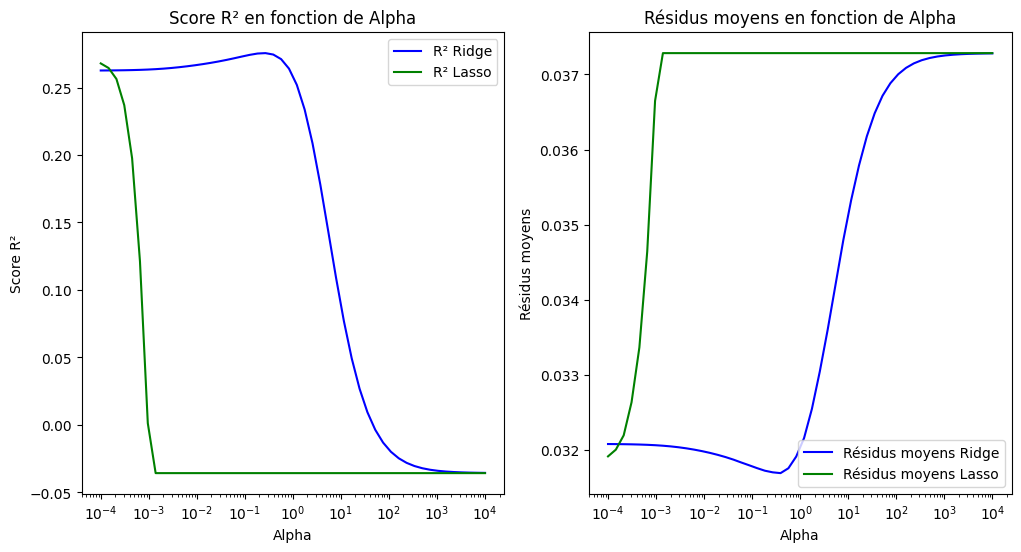

In [67]:
# Utiliser les meilleurs alpha pour ajuster le modèle final

meil_ridge = Ridge(alpha=alpha_ridge)
meil_lasso = Lasso(alpha=alpha_lasso)

meil_ridge.fit(X, y)
meil_lasso.fit(X, y)

#appliquer les prédiction 
pred_ridge = meil_ridge.predict(X)
pred_lasso = meil_lasso.predict(X)

# Calcul des R² 
ridge_r2 = r2_score(y, pred_ridge)
lasso_r2 = r2_score(y, pred_lasso)

print(f"Score R2 pour Ridge  {ridge_r2:.3f}")
print(f"Score R2 pour Lasso  {lasso_r2:.3f}")

plt.figure(figsize=(12, 6))

# graphe des scores R² pour Ridge et Lasso
plt.subplot(1, 2, 1)
plt.plot(alpha, ridge_scr, label='R² Ridge', color='blue')
plt.plot(alpha, lasso_scr, label='R² Lasso', color='green')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Score R²')
plt.title('Score R² en fonction de Alpha')
plt.legend()

# graphe pour les residus 
plt.subplot(1, 2, 2)
plt.plot(alpha, ris1_moy, label='Résidus moyens Ridge', color='blue')
plt.plot(alpha, ris2_moy, label='Résidus moyens Lasso', color='green')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Résidus moyens')
plt.title('Résidus moyens en fonction de Alpha')
plt.legend()

plt.show()


Ce graphe montre l'impact de la régularisation $\alpha$ sur les modèles Ridge et Lasso, en termes de score $R^2$ et de résidus moyens.

1 er graphe : Pour les score $R^2$ en fonction de $\alpha$

* ridge:
Le score $R^2$ reste stable pour les petites valeurs de $\alpha$ (ce qui indique un bon ajustement du modèle), mais commence à diminuer lorsque $\alpha$ augmente. Dans ce cas Ridge commence à pénaliser les coefficients pour des valeurs d'$\alpha$ plus élevées, ce qui fait baisser la performance du modèle.

* lasso: 
Le score $R^2$ baisse beaucoup plus rapidement que Ridge lorsque $\alpha$ augmente car Lasso élimine des variables du modèle lorsque la régularisation augmente, ce qui entraîne une perte de précision.

2 eme graphe : Pour les résidus moyen en fonction de $\alpha$

* ridge : 
Les résidus sont faibles pour de petites valeurs d'$\alpha$, puis augmentent lorsque la régularisation devient plus forte. lorsque $\alpha$ est élevé les résidus augmentent (le modèle devient moins précis).

* lasso : les résidus augmentent beaucoup plus rapidement avec des valeurs plus petites de $\alpha$ car lasso applique une  pénalisation sur les coefficients.



## réferences utilisées : 

(r2_score) : [https://scikit-learn.org/1.2/modules/generated/sklearn.metrics.r2_score.html] 

(k_means) : [https://scikit-learn.org/stable/modules/clustering.html#k-means]

(SGD) : [https://scikit-learn.org/stable/modules/sgd.html]


